In [ ]:
import numpy as np
from scipy.linalg import orth
import time
import os
from scipy.linalg import svdvals

# Set random seed for reproducibility
np.random.seed(42)

# Matrix dimensions
m = 10000  # Number of rows
n = 100    # Number of columns
d = n      # For NG/NB matrices, set d = n as per context

In [ ]:
# Function to generate UG and UB matrices (based on Table 10, Page 40)
def generate_ug_ub_matrix(m, n, kappa):
    start_time = time.time()

    # Generate orthogonal U (m x n)
    U = orth(np.random.randn(m, n))

    # Generate diagonal matrix S with singular values
    singular_values = np.linspace(1, 1/kappa, n)
    S = np.diag(singular_values)

    # Generate orthogonal V (n x n)
    V = orth(np.random.randn(n, n))

    # Compute A = U S V^T
    A = U @ S @ V.T

    # Generate x_true
    x_true = np.random.randn(n)

    # Compute b = A x_true + epsilon
    b_clean = A @ x_true
    epsilon = np.random.randn(m)
    epsilon = 0.25 * np.linalg.norm(b_clean) / np.linalg.norm(epsilon) * epsilon
    b = b_clean + epsilon

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A, x_true, b, elapsed_time

In [ ]:
import shutil
shutil.rmtree("/content/matrix_data")

In [ ]:
# NG/NB Matrix Generation (aligned with minor_ls_final.py)
def generate_ng_nb_matrix(m, n, kappa, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    d_half = n // 2
    B = np.random.randn(m - d_half, d_half)
    R = 1e-2 * np.random.rand(m - d_half, d_half)
    I = np.eye(d_half)
    Zero = np.zeros((d_half, d_half))
    sigma_B = np.linalg.norm(B, 2)
    alpha = np.sqrt((kappa - 1) / sigma_B) / 10
    A_top = np.hstack([alpha * B, R])
    A_bottom = np.hstack([Zero, I])
    A = np.vstack([A_top, A_bottom])
    s = svdvals(A)
    cond = s.max() / s.min()
    if abs(cond - kappa) > 1e5 and kappa > 100:
        alpha *= np.sqrt(kappa / cond)
        A_top = np.hstack([alpha * B, R])
        A = np.vstack([A_top, A_bottom])
    x_true = np.random.randn(n)
    b_clean = A @ x_true
    epsilon = np.random.randn(m)
    epsilon = 0.25 * np.linalg.norm(b_clean) / np.linalg.norm(epsilon) * epsilon
    b = b_clean + epsilon
    end_time = time.time()
    return A, x_true, b, end_time - start_time


In [ ]:
# Main function to generate all matrices
def main():
    # Condition numbers (Page 39)
    kappa_good = 5      # For UG and NG
    kappa_bad = 1e6     # For UB and NB

    # Dictionary to store results
    results = {}

    # Generate UG matrix
    A_ug, x_true_ug, b_ug, time_ug = generate_ug_ub_matrix(m, n, kappa_good)
    results['UG'] = {'A': A_ug, 'x_true': x_true_ug, 'b': b_ug, 'time': time_ug}

    # Generate UB matrix
    A_ub, x_true_ub, b_ub, time_ub = generate_ug_ub_matrix(m, n, kappa_bad)
    results['UB'] = {'A': A_ub, 'x_true': x_true_ub, 'b': b_ub, 'time': time_ub}

    # Generate NG matrix
    A_ng, x_true_ng, b_ng, time_ng = generate_ng_nb_matrix(m, n, kappa_good)
    results['NG'] = {'A': A_ng, 'x_true': x_true_ng, 'b': b_ng, 'time': time_ng}

    # Generate NB matrix
    A_nb, x_true_nb, b_nb, time_nb = generate_ng_nb_matrix(m, n, kappa_bad)
    results['NB'] = {'A': A_nb, 'x_true': x_true_nb, 'b': b_nb, 'time': time_nb}

    # Print timing results
    print("Timing Results (seconds):")
    for matrix_type in results:
        print(f"{matrix_type}: {results[matrix_type]['time']:.4f} seconds")

    # Save results to files (optional, can be removed if not needed)
    output_dir = "matrix_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for matrix_type in results:
        np.save(os.path.join(output_dir, f"A_{matrix_type}.npy"), results[matrix_type]['A'])
        np.save(os.path.join(output_dir, f"x_true_{matrix_type}.npy"), results[matrix_type]['x_true'])
        np.save(os.path.join(output_dir, f"b_{matrix_type}.npy"), results[matrix_type]['b'])
        with open(os.path.join(output_dir, f"time_{matrix_type}.txt"), 'w') as f:
            f.write(str(results[matrix_type]['time']))

    return results

if __name__ == "__main__":
    results = main()

Timing Results (seconds):
UG: 1.3319 seconds
UB: 0.5458 seconds
NG: 0.5637 seconds
NB: 0.3630 seconds


In [ ]:
for matrix_type in results:
    print(f"{matrix_type}:")
    print(f"  A shape: {results[matrix_type]['A'].shape}")
    print(f"  x_true shape: {results[matrix_type]['x_true'].shape}")
    print(f"  b shape: {results[matrix_type]['b'].shape}")
    print(f"  time: {results[matrix_type]['time']}")

UG:
  A shape: (10000, 100)
  x_true shape: (100,)
  b shape: (10000,)
  time: 1.3319458961486816
UB:
  A shape: (10000, 100)
  x_true shape: (100,)
  b shape: (10000,)
  time: 0.5457501411437988
NG:
  A shape: (10000, 100)
  x_true shape: (100,)
  b shape: (10000,)
  time: 0.5636703968048096
NB:
  A shape: (10000, 100)
  x_true shape: (100,)
  b shape: (10000,)
  time: 0.36302781105041504


In [ ]:
# Compute leverage scores
def compute_leverage_scores(A):
    ATA = A.T @ A
    try:
        ATA_inv = np.linalg.inv(ATA)
    except np.linalg.LinAlgError:
        ATA_inv = np.linalg.pinv(ATA)
    leverage_scores = np.array([A[i] @ ATA_inv @ A[i].T for i in range(m)])
    leverage_scores = np.maximum(leverage_scores, 0)  # Ensure non-negative
    return leverage_scores / np.sum(leverage_scores) if np.sum(leverage_scores) > 0 else np.ones(m) / m

new one below

In [ ]:
import numpy as np

def compute_leverage_scores(A):
    ATA = A.T @ A
    try:
        ATA_inv = np.linalg.inv(ATA)
    except np.linalg.LinAlgError:
        ATA_inv = np.linalg.pinv(ATA)

    # Vectorized computation of leverage scores
    # (A @ ATA_inv) * A summed across columns
    temp = A @ ATA_inv
    leverage_scores = np.einsum('ij,ij->i', temp, A)  # efficient row-wise dot product

    leverage_scores = np.maximum(leverage_scores, 0)  # Ensure non-negative
    total = np.sum(leverage_scores)
    return leverage_scores / total if total > 0 else np.ones(A.shape[0]) / A.shape[0]


In [ ]:
import numpy as np
from scipy.linalg import orth
import time
import os

# Set random seed for reproducibility
np.random.seed(42)

# Matrix dimensions
m = 10000  # Rows (n in paper)
n = 100    # Columns (d in paper)

In [ ]:
# Gaussian Sketching
def gaussian_sketching(A, b, k, seed=42):

    np.random.seed(seed)

    # Generate Gaussian projection matrix
    Pi = np.random.randn(k, m) / np.sqrt(k)
    start_time_s = time.time()
    # Compute sketches
    Pi_A = Pi @ A  # k x d
    Pi_b = Pi @ b   # k
    end_time_s = time.time()

    # Solve regression: x_hat = (Pi_A^T Pi_A)^(-1) Pi_A^T Pi_b
    start_time = time.time()
    x_hat, _, _, _ = np.linalg.lstsq(Pi_A, Pi_b, rcond=None)
    end_time = time.time()
    S=end_time - start_time + end_time_s - start_time_s
    print(f"Time for regression: {end_time - start_time}")
    print(f"Time for skecthing: {end_time_s - start_time_s}")
    return x_hat, k, k, end_time - start_time

In [ ]:
 # SRHT (Subsampled Randomized Hadamard Transform,  PHD = SRHT)
def srht_sketching(A, b, k, seed=42):

    np.random.seed(seed)
    # Hadamard matrix (simplified, using FFT-like structure)
    from scipy.linalg import hadamard
    H = hadamard(m) if m & (m - 1) == 0 else np.random.randn(m, m)  # Fallback if m not power of 2
    H = H / np.sqrt(m)
    # Random diagonal sign matrix
    D = np.diag(np.random.choice([-1, 1], m))
    # Subsampling
    indices = np.random.choice(m, k, replace=False)
    Pi = np.sqrt(m / k) * H[indices] @ D
    start_time = time.time()
    # Compute sketches
    Pi_A = Pi @ A
    Pi_b = Pi @ b
    # start_time = time.time()
    x_hat = np.linalg.lstsq(Pi_A, Pi_b, rcond=None)[0]
    end_time = time.time()
    return x_hat, k, k, end_time - start_time

In [ ]:
# CountSketch (inspired by minor_ls_final.py)
def countsketch_sketching(A, b, k, seed=42):
    np.random.seed(seed)
    m, n = A.shape
    Pi_A = np.zeros((k, n))
    Pi_b = np.zeros(k)

    # Random hashing and sign flipping
    h = np.random.randint(0, k, m)  # Hash each row to a bucket
    s = np.random.choice([-1, 1], m)  # Random signs
    start_time = time.time()
    # Build sketch
    for i in range(m):
        Pi_A[h[i]] += s[i] * A[i] / np.sqrt(k)
        Pi_b[h[i]] += s[i] * b[i] / np.sqrt(k)

    # Solve least squares
    # start_time = time.time()
    x_hat, _, _, _ = np.linalg.lstsq(Pi_A, Pi_b, rcond=None)
    end_time = time.time()

    return x_hat, k, k, end_time - start_time


In [ ]:
import numpy as np
import time

def priority_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Compute row norms (for standard Priority Sampling)
    row_norms_A = np.sum(A**2, axis=1)  # ||A_i||_2^2
    row_norms_b = b**2                   # ||b_i||_2^2 (since b is a vector)

    # Step 2: Generate shared random hash
    h = np.random.uniform(0, 1, m)

    # Step 3: Compute ranks and thresholds
    R_A = h / (row_norms_A + 1e-10)  # Avoid division by zero
    R_A[row_norms_A == 0] = np.inf   # Skip zero rows
    tau_A = np.partition(R_A, k)[k] if np.sum(row_norms_A > 0) > k else np.inf

    R_b = h / (row_norms_b + 1e-10)
    R_b[row_norms_b == 0] = np.inf
    tau_b = np.partition(R_b, k)[k] if np.sum(row_norms_b > 0) > k else np.inf

    # Step 4: Select samples
    I_A = np.where(R_A < tau_A)[0]
    I_b = np.where(R_b < tau_b)[0]
    T = np.intersect1d(I_A, I_b)  # Overlapping indices

    # Step 5: Compute weighted sketch
    W = np.zeros(n)
    for i in T:
        p_i = min(1, row_norms_A[i] * tau_A, row_norms_b[i] * tau_b)
        if p_i > 0:
            W += (A[i] * b[i]) / p_i  # Unbiased estimate of A^T b
    # start_time = time.time()
    # Step 6: Solve least squares (using lstsq, not explicit inverse)
    x_hat, residuals, rank, _ = np.linalg.lstsq(A.T @ A, W, rcond=None)

    end_time = time.time()
    return x_hat, len(I_A), len(I_b), end_time - start_time

In [ ]:
def threshold_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Compute row norms (for Threshold Sampling)
    row_norms_A = np.sum(A**2, axis=1)  # ||A_i||_2^2
    row_norms_b = b**2                   # ||b_i||_2^2 (since b is a vector)

    # Step 2: Compute thresholds
    tau_A = k / np.sum(row_norms_A) if np.sum(row_norms_A) > 0 else np.inf
    tau_b = k / np.sum(row_norms_b) if np.sum(row_norms_b) > 0 else np.inf

    # Step 3: Generate shared random hash
    h = np.random.uniform(0, 1, m)

    # Step 4: Sample rows (Threshold Sampling)
    I_A = np.where(h <= tau_A * row_norms_A)[0]  # Indices where h(i) ≤ τ_A * ||A_i||^2
    I_b = np.where(h <= tau_b * row_norms_b)[0]  # Indices where h(i) ≤ τ_b * b_i^2
    T = np.intersect1d(I_A, I_b)  # Overlapping indices

    # Step 5: Compute weighted estimate of A^T b
    W = np.zeros(n)
    for i in T:
        p_i = min(1, tau_A * row_norms_A[i], tau_b * row_norms_b[i])
        if p_i > 0:
            W += (A[i] * b[i]) / p_i  # Unbiased estimate
    # start_time = time.time()
    # Step 6: Solve least squares (using lstsq, not explicit inverse)
    x_hat, residuals, rank, _ = np.linalg.lstsq(A.T @ A, W, rcond=None)

    end_time = time.time()
    return x_hat, len(I_A), len(I_b), end_time - start_time

In [ ]:
import numpy as np
import time

def leverage_score_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Compute leverage scores
    leverage_scores = compute_leverage_scores(A)  # Ensure this returns ||U_i||^2 where A = UΣV^T
    p_i = leverage_scores / np.sum(leverage_scores)  # Normalize to probabilities

    # Step 2: Sample rows proportional to p_i (without replacement)
    T = np.random.choice(m, size=k, replace=False, p=p_i)

    # Step 3: Reweight sampled rows and construct SA, Sb
    weights = 1.0 / np.sqrt(k * p_i[T])  # Correct weighting
    SA = A[T] * weights.reshape(-1, 1)   # Rescale rows of A
    Sb = b[T] * weights                  # Rescale entries of b
    # start_time = time.time()
    # Step 4: Solve least squares
    x_hat, _, _, _ = np.linalg.lstsq(SA, Sb, rcond=None)

    end_time = time.time()
    return x_hat, k, k, end_time - start_time

In [ ]:
def sqrt_leverage_score_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Compute leverage scores and take square roots
    leverage_scores = compute_leverage_scores(A)
    sqrt_leverage = np.sqrt(np.maximum(leverage_scores, 1e-10))  # Avoid division by zero

    # Step 2: Compute sampling probabilities (normalized)
    sum_sqrt = np.sum(sqrt_leverage)
    p_i = sqrt_leverage / sum_sqrt if sum_sqrt > 0 else np.ones(m) / m

    # Step 3: Sample k rows with replacement (indices)
    sampled_indices = np.random.choice(m, size=k, p=p_i, replace=True)

    # Step 4: Compute weights = 1 / sqrt(k * p_i) for sampled rows
    weights = 1.0 / np.sqrt(k * p_i[sampled_indices])

    # Step 5: Construct weighted sketch (SA, Sb)
    SA = A[sampled_indices] * weights[:, np.newaxis]  # Rescale rows of A
    Sb = b[sampled_indices] * weights                 # Rescale entries of b
    # start_time = time.time()
    # Step 6: Solve weighted least squares (using lstsq)
    x_hat, _, _, _ = np.linalg.lstsq(SA, Sb, rcond=None)

    end_time = time.time()
    return x_hat, k, k, end_time - start_time

In [ ]:
def uniform_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Sample k rows uniformly at random (with replacement)
    sampled_indices = np.random.choice(m, size=k, replace=True)

    # Step 2: Construct the sketch (no weighting needed for uniform sampling)
    SA = A[sampled_indices]  # (k × n) matrix
    Sb = b[sampled_indices]  # (k × 1) vector
    # start_time = time.time()
    # Step 3: Solve the subsampled least-squares problem
    x_hat, _, _, _ = np.linalg.lstsq(SA, Sb, rcond=None)

    end_time = time.time()
    return x_hat, k, k, end_time - start_time

In [ ]:
def row_norm_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    start_time = time.time()
    m, n = A.shape

    # Step 1: Compute row norms (squared L2 norms)
    row_norms = np.sum(A**2, axis=1)  # Shape: (m,)

    # Step 2: Compute sampling probabilities
    sum_norms = np.sum(row_norms)
    p_i = row_norms / sum_norms if sum_norms > 1e-10 else np.ones(m) / m

    # Step 3: Sample k rows with replacement
    sampled_indices = np.random.choice(m, size=k, p=p_i, replace=True)

    # Step 4: Compute weights (1 / sqrt(k * p_i) for sampled rows
    weights = 1.0 / np.sqrt(k * p_i[sampled_indices])

    # Step 5: Construct weighted sketch
    SA = A[sampled_indices] * weights[:, np.newaxis]  # Rescale rows of A
    Sb = b[sampled_indices] * weights                # Rescale entries of b
    # start_time = time.time()
    # Step 6: Solve weighted least squares
    x_hat, _, _, _ = np.linalg.lstsq(SA, Sb, rcond=None)

    end_time = time.time()
    return x_hat, k, k, end_time - start_time

In [ ]:
import shutil
shutil.rmtree("/content/sketch_data_all")

In [ ]:
import numpy as np
import time
from typing import Dict, Any

def priority_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    m, n = A.shape
    start_time = time.time()

    # Using friend's priority sampling approach for A
    hash_values = np.random.uniform(0, 1, m)
    r_A = np.full(m, np.inf)
    row_norms_A = np.sum(A**2, axis=1)
    non_zero_A = row_norms_A > 0
    r_A[non_zero_A] = hash_values[non_zero_A] / row_norms_A[non_zero_A]
    tau_A = np.partition(r_A, k)[k] if np.sum(non_zero_A) > k else np.inf
    I_A = np.where(r_A < tau_A)[0]

    # Using friend's approach for b (modified)
    r_b = np.full(m, np.inf)
    row_norms_b = b**2
    non_zero_b = row_norms_b > 0
    r_b[non_zero_b] = hash_values[non_zero_b] / row_norms_b[non_zero_b]
    tau_b = np.partition(r_b, k)[k] if np.sum(non_zero_b) > k else np.inf
    I_b = np.where(r_b < tau_b)[0]

    # Your original weighting and solving logic
    T = np.intersect1d(I_A, I_b)
    W = np.zeros(n)
    for i in T:
        p_i = min(1, row_norms_A[i] * tau_A, row_norms_b[i] * tau_b)
        if p_i > 0:
            W += (A[i] * b[i]) / p_i

    x_hat = np.linalg.lstsq(A.T @ A, W, rcond=None)[0]

    return x_hat, len(I_A), len(I_b), time.time() - start_time

def threshold_sampling(A, b, k, seed=42):
    np.random.seed(seed)
    m, n = A.shape
    start_time = time.time()

    # Using friend's threshold sampling approach with shared hash
    hash_values = np.random.uniform(0, 1, m)

    # For A
    row_norms_A = np.sum(A**2, axis=1)
    A_norm_sq = np.sum(row_norms_A)
    tau_A = k / A_norm_sq if A_norm_sq > 0 else np.inf
    I_A = np.where(hash_values <= tau_A * row_norms_A)[0]

    # For b
    row_norms_b = b**2
    b_norm_sq = np.sum(row_norms_b)
    tau_b = k / b_norm_sq if b_norm_sq > 0 else np.inf
    I_b = np.where(hash_values <= tau_b * row_norms_b)[0]

    # Your original weighting and solving logic
    T = np.intersect1d(I_A, I_b)
    W = np.zeros(n)
    for i in T:
        p_i = min(1, tau_A * row_norms_A[i], tau_b * row_norms_b[i])
        if p_i > 0:
            W += (A[i] * b[i]) / p_i

    x_hat = np.linalg.lstsq(A.T @ A, W, rcond=None)[0]

    return x_hat, len(I_A), len(I_b), time.time() - start_time

In [ ]:
# Main function
def main():
    input_dir = "matrix_data"
    matrix_types = ['UG', 'UB', 'NG', 'NB']
    methods = [
        # ('Gaussian', gaussian_sketching)
         ('Priority', priority_sampling),
        ('Threshold', threshold_sampling)]
    results = {}
    full_matrix_times = {}  # Dictionary to store full matrix computation times

    epsilon = 0.1
    k = int(np.ceil(n / epsilon))  # k = 1000

    for matrix_type in matrix_types:
        A = np.load(os.path.join(input_dir, f"A_{matrix_type}.npy"))
        b = np.load(os.path.join(input_dir, f"b_{matrix_type}.npy"))
        x_true = np.load(os.path.join(input_dir, f"x_true_{matrix_type}.npy"))

        # Compute full matrix solution and time it
        start_time = time.time()
        x_full, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        error = np.linalg.norm(A @ x_full - b) / np.linalg.norm(b) if np.linalg.norm(b) > 0 else 0
        full_time = time.time() - start_time
        full_matrix_times[matrix_type] = full_time

        results[matrix_type] = {}

        for method_name, method_func in methods:
            x_hat, size_A, size_b, time_taken = method_func(A, b, k)
            error = np.linalg.norm(A @ x_hat - b) / np.linalg.norm(b) if np.linalg.norm(b) > 0 else 0
            results[matrix_type][method_name] = {
                'x_hat': x_hat,
                'error': error,
                'sketch_size_A': size_A,
                'sketch_size_b': size_b,
                'time': time_taken,
                'speedup': full_time / time_taken if time_taken > 0 else float('inf')
            }

    # Print results
    print("Sketching Comparison Results:")
    for matrix_type in matrix_types:
        print(f"\nMatrix {matrix_type}:")
        print(f"Full matrix solution time: {full_matrix_times[matrix_type]:.4f} seconds")
        for method_name in [m[0] for m in methods]:
            res = results[matrix_type][method_name]
            print(f"{method_name}:")
            print(f"  Error: {res['error']:.6f}")
            print(f"  Time: {res['time']:.4f} seconds (Speedup: {res['speedup']:.1f}x)")
            print(f"  Sketch size (A): {res['sketch_size_A']} rows")
            print(f"  Sketch size (b): {res['sketch_size_b']} rows")

    # Save results
    output_dir = "sketch_data_all"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for matrix_type in matrix_types:
        for method_name in [m[0] for m in methods]:
            np.save(os.path.join(output_dir, f"x_hat_{matrix_type}_{method_name}.npy"),
                    results[matrix_type][method_name]['x_hat'])
            with open(os.path.join(output_dir, f"stats_{matrix_type}_{method_name}.txt"), 'w') as f:
                res = results[matrix_type][method_name]
                f.write(f"Error: {res['error']}\n")
                f.write(f"Time: {res['time']}\n")
                f.write(f"Speedup: {res['speedup']}\n")
                f.write(f"Sketch size A: {res['sketch_size_A']}\n")
                f.write(f"Sketch size b: {res['sketch_size_b']}\n")
        # Save full matrix time
        with open(os.path.join(output_dir, f"full_matrix_time_{matrix_type}.txt"), 'w') as f:
            f.write(f"{full_matrix_times[matrix_type]}")

    return results, full_matrix_times

if __name__ == "__main__":
    results, full_matrix_times = main()

Sketching Comparison Results:

Matrix UG:
Full matrix solution time: 0.0599 seconds
Priority:
  Error: 0.454182
  Time: 0.0155 seconds (Speedup: 3.9x)
  Sketch size (A): 1000 rows
  Sketch size (b): 1000 rows
Threshold:
  Error: 0.451572
  Time: 0.0184 seconds (Speedup: 3.3x)
  Sketch size (A): 1014 rows
  Sketch size (b): 1006 rows

Matrix UB:
Full matrix solution time: 0.0671 seconds
Priority:
  Error: 0.601782
  Time: 0.0158 seconds (Speedup: 4.2x)
  Sketch size (A): 1000 rows
  Sketch size (b): 1000 rows
Threshold:
  Error: 0.595279
  Time: 0.0153 seconds (Speedup: 4.4x)
  Sketch size (A): 1020 rows
  Sketch size (b): 1024 rows

Matrix NG:
Full matrix solution time: 0.0650 seconds
Priority:
  Error: 0.377772
  Time: 0.0153 seconds (Speedup: 4.3x)
  Sketch size (A): 1000 rows
  Sketch size (b): 1000 rows
Threshold:
  Error: 0.409585
  Time: 0.0153 seconds (Speedup: 4.3x)
  Sketch size (A): 897 rows
  Sketch size (b): 870 rows

Matrix NB:
Full matrix solution time: 0.0665 seconds
Pri

Time for regression: 0.005213260650634766
Time for skecthing: 0.022291898727416992
Time for regression: 0.0046732425689697266
Time for skecthing: 0.025002717971801758
Time for regression: 0.004494190216064453
Time for skecthing: 0.02190876007080078
Time for regression: 0.00464630126953125
Time for skecthing: 0.023286819458007812
Time for regression: 0.004293203353881836
Time for skecthing: 0.022043704986572266
Time for regression: 0.005478382110595703
Time for skecthing: 0.04301285743713379
Time for regression: 0.005559682846069336
Time for skecthing: 0.045070648193359375
Time for regression: 0.00559687614440918
Time for skecthing: 0.04615497589111328
Time for regression: 0.0055086612701416016
Time for skecthing: 0.04496288299560547
Time for regression: 0.007292985916137695
Time for skecthing: 0.042984962463378906
Time for regression: 0.006646633148193359
Time for skecthing: 0.06365823745727539
Time for regression: 0.006783246994018555
Time for skecthing: 0.06625676155090332
Time for r

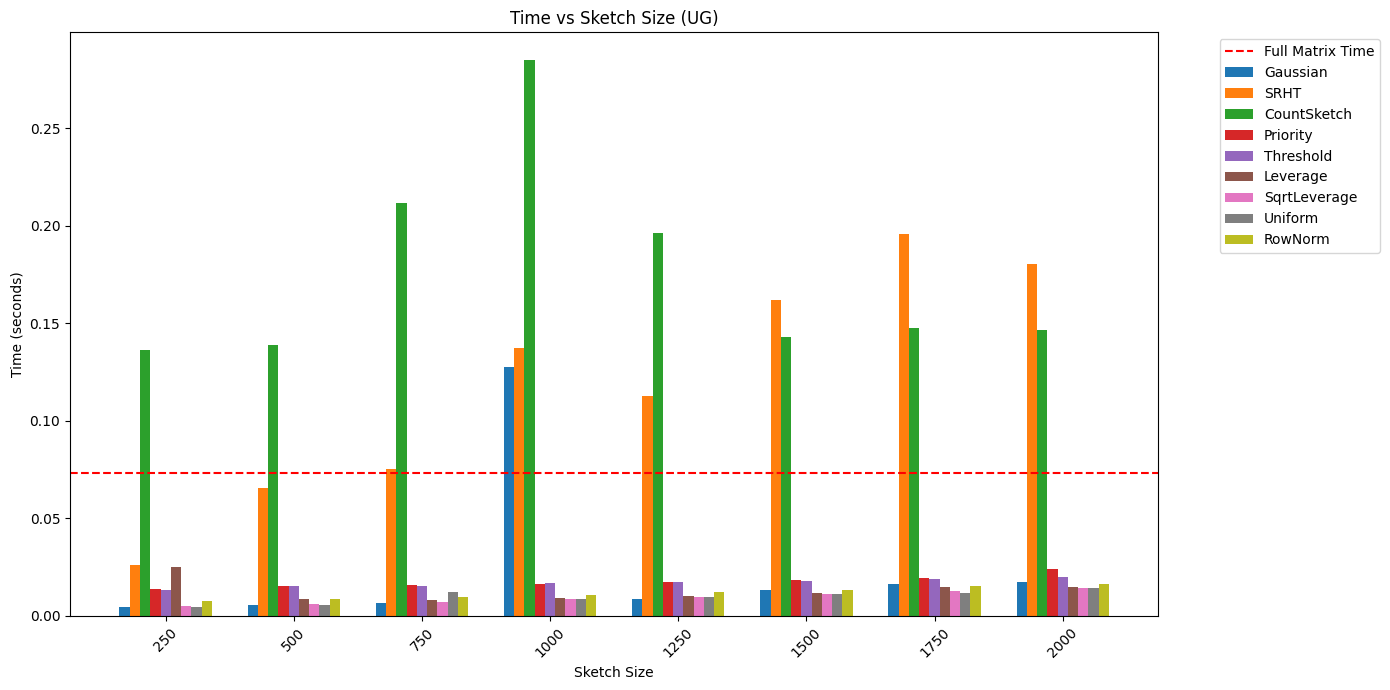

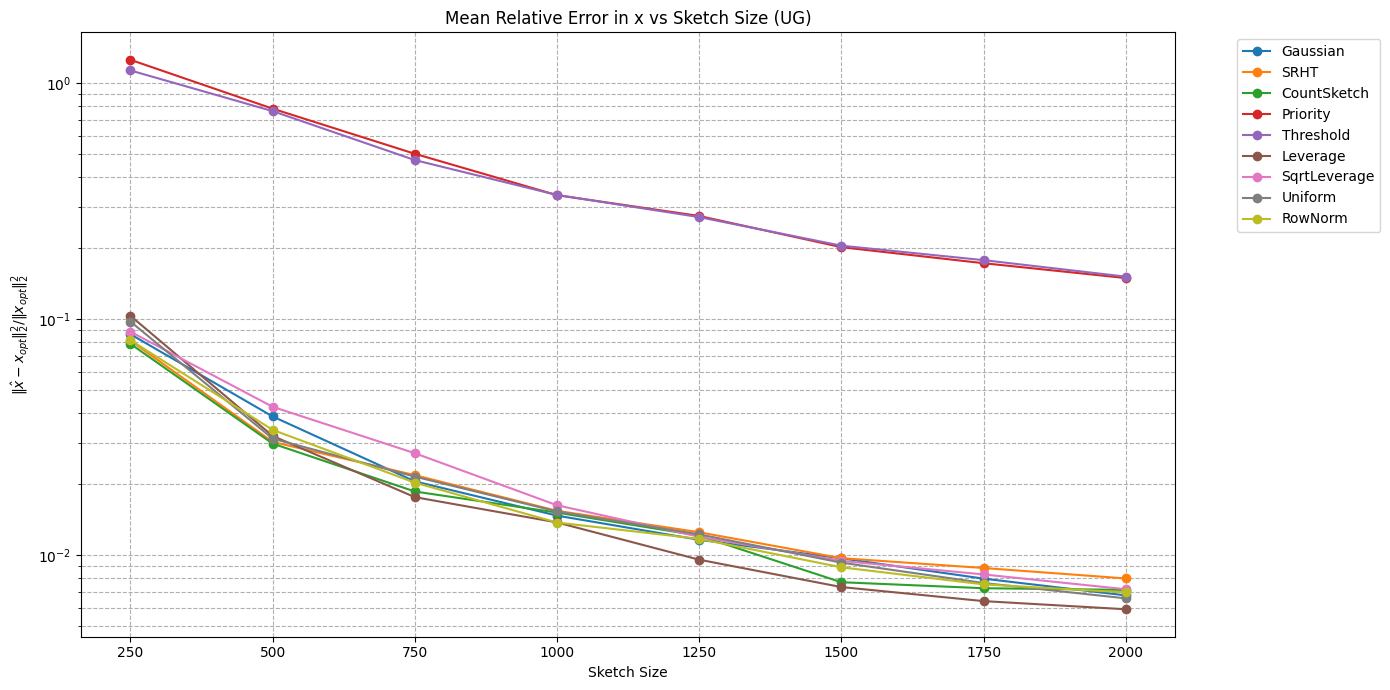

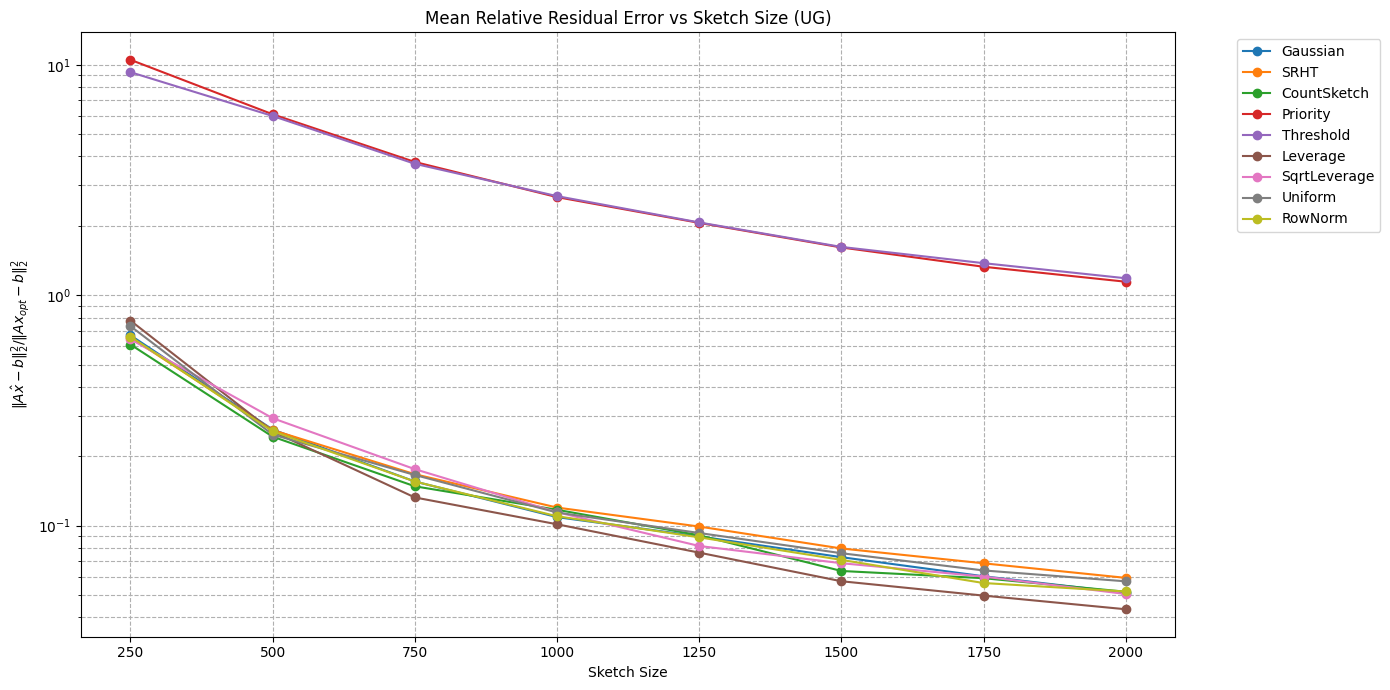

Time for regression: 0.004489421844482422
Time for skecthing: 0.022217512130737305
Time for regression: 0.004276752471923828
Time for skecthing: 0.022141456604003906
Time for regression: 0.0042612552642822266
Time for skecthing: 0.02201366424560547
Time for regression: 0.004256010055541992
Time for skecthing: 0.025173664093017578
Time for regression: 0.004275321960449219
Time for skecthing: 0.022412538528442383
Time for regression: 0.005357980728149414
Time for skecthing: 0.04849720001220703
Time for regression: 0.005426645278930664
Time for skecthing: 0.05333137512207031
Time for regression: 0.005444049835205078
Time for skecthing: 0.05887007713317871
Time for regression: 0.005479335784912109
Time for skecthing: 0.04654407501220703
Time for regression: 0.015695810317993164
Time for skecthing: 0.09847187995910645
Time for regression: 0.4872286319732666
Time for skecthing: 0.28069472312927246
Time for regression: 0.01306462287902832
Time for skecthing: 0.2982351779937744
Time for regres

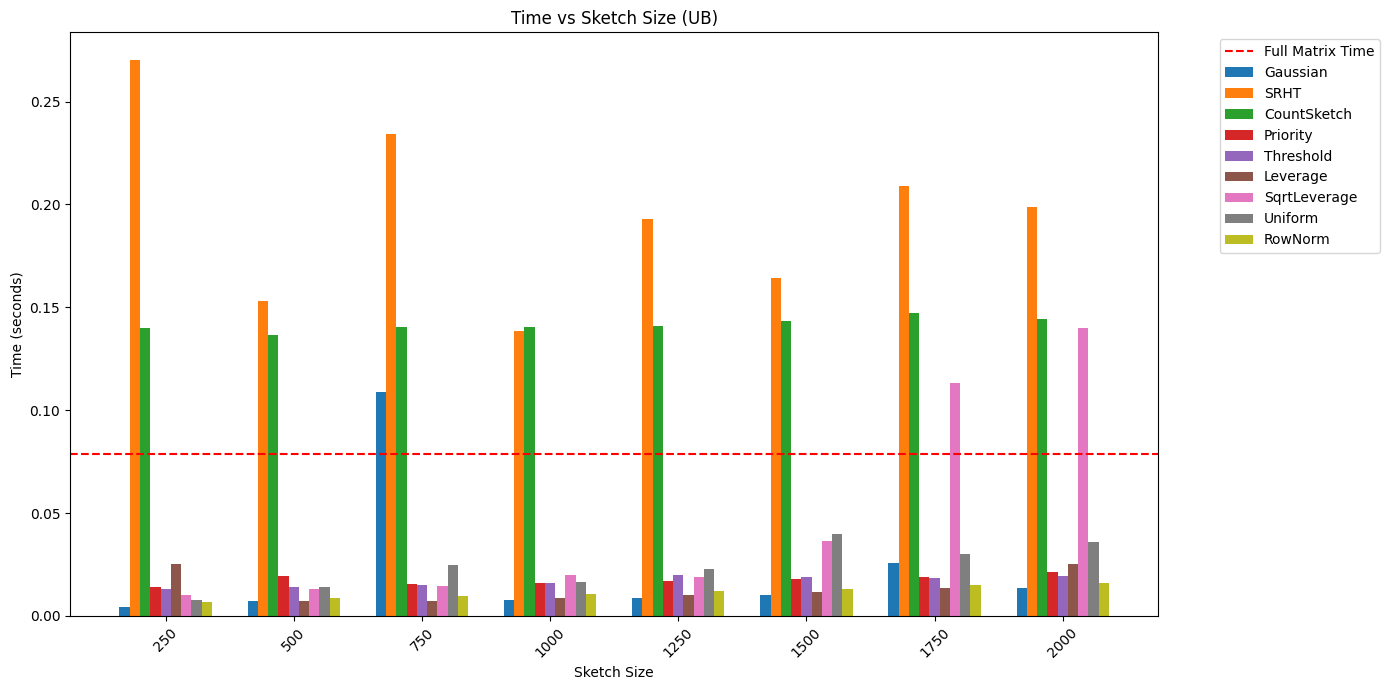

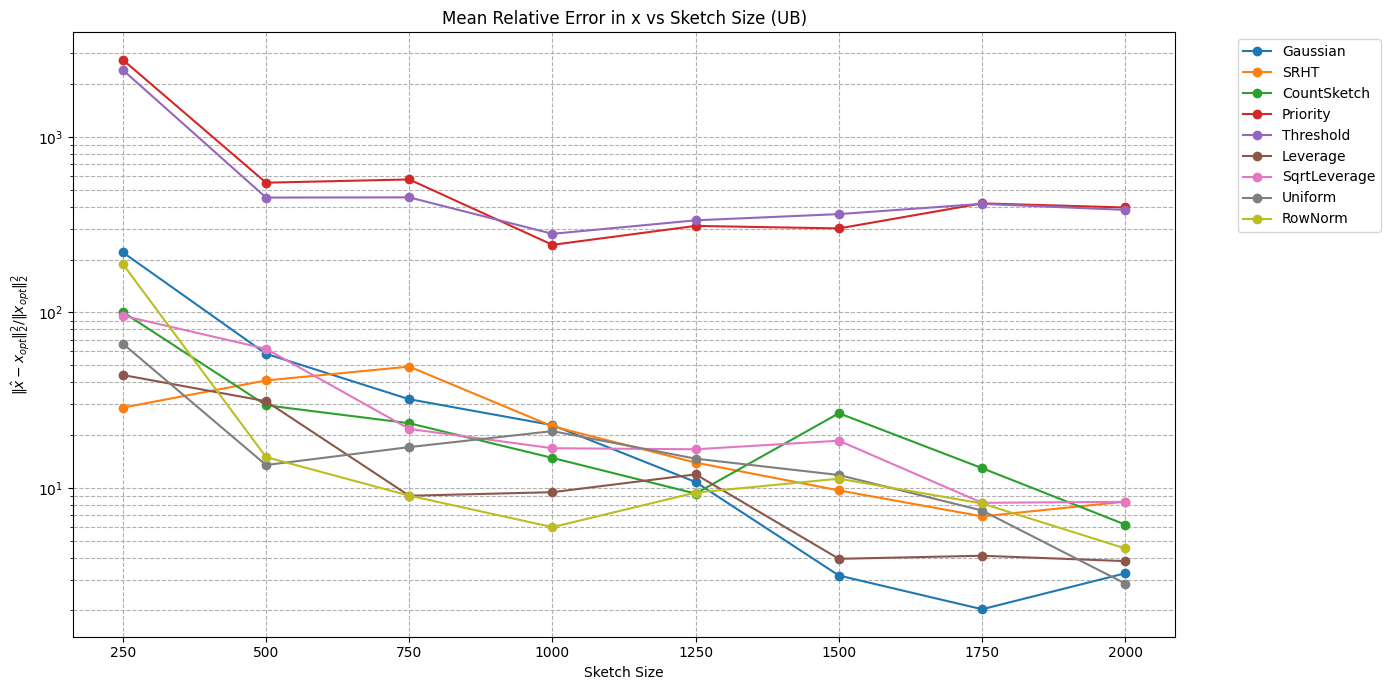

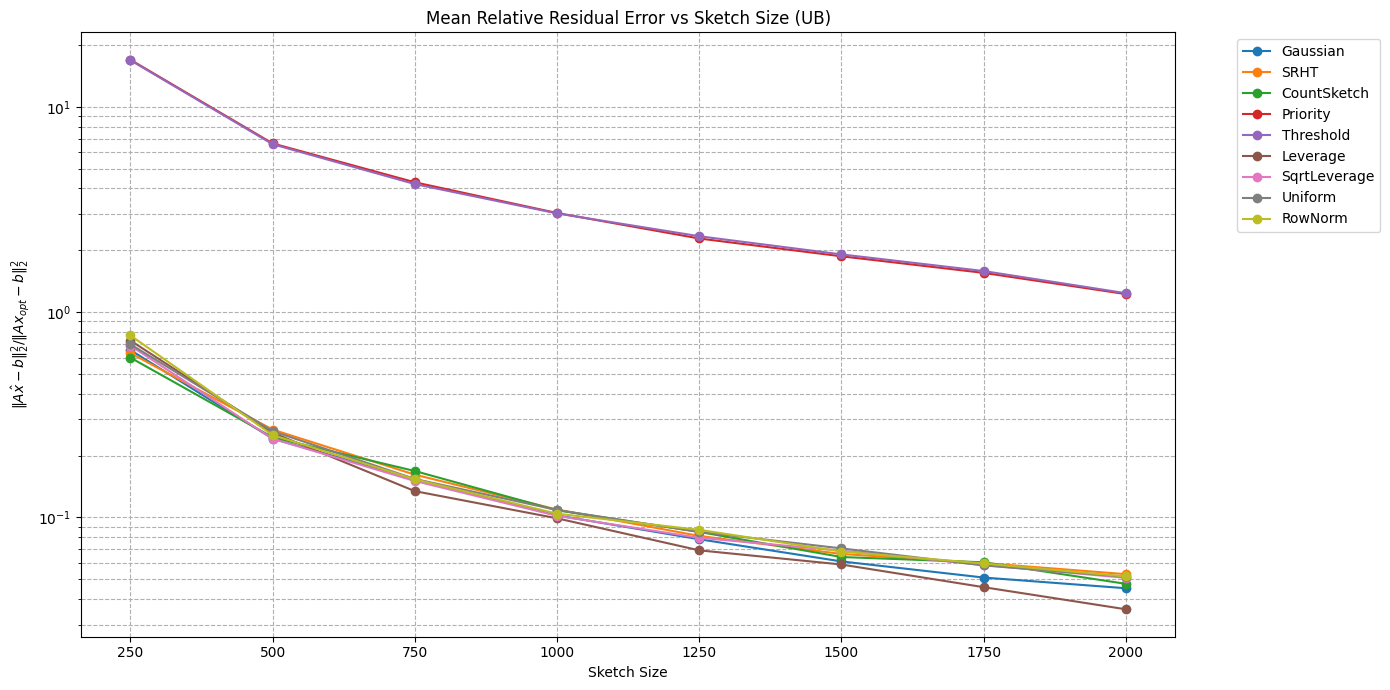

Time for regression: 0.004427909851074219
Time for skecthing: 0.02203679084777832
Time for regression: 0.004361629486083984
Time for skecthing: 0.022020339965820312
Time for regression: 0.004369258880615234
Time for skecthing: 0.021959304809570312
Time for regression: 0.004426479339599609
Time for skecthing: 0.02198171615600586
Time for regression: 0.004400014877319336
Time for skecthing: 0.021905899047851562
Time for regression: 0.00553441047668457
Time for skecthing: 0.04409527778625488
Time for regression: 0.005669593811035156
Time for skecthing: 0.06738734245300293
Time for regression: 0.00551295280456543
Time for skecthing: 0.06707191467285156
Time for regression: 0.010404348373413086
Time for skecthing: 0.06090497970581055
Time for regression: 0.0055942535400390625
Time for skecthing: 0.04324221611022949
Time for regression: 0.006507396697998047
Time for skecthing: 0.0603177547454834
Time for regression: 0.006577968597412109
Time for skecthing: 0.059793949127197266
Time for regre

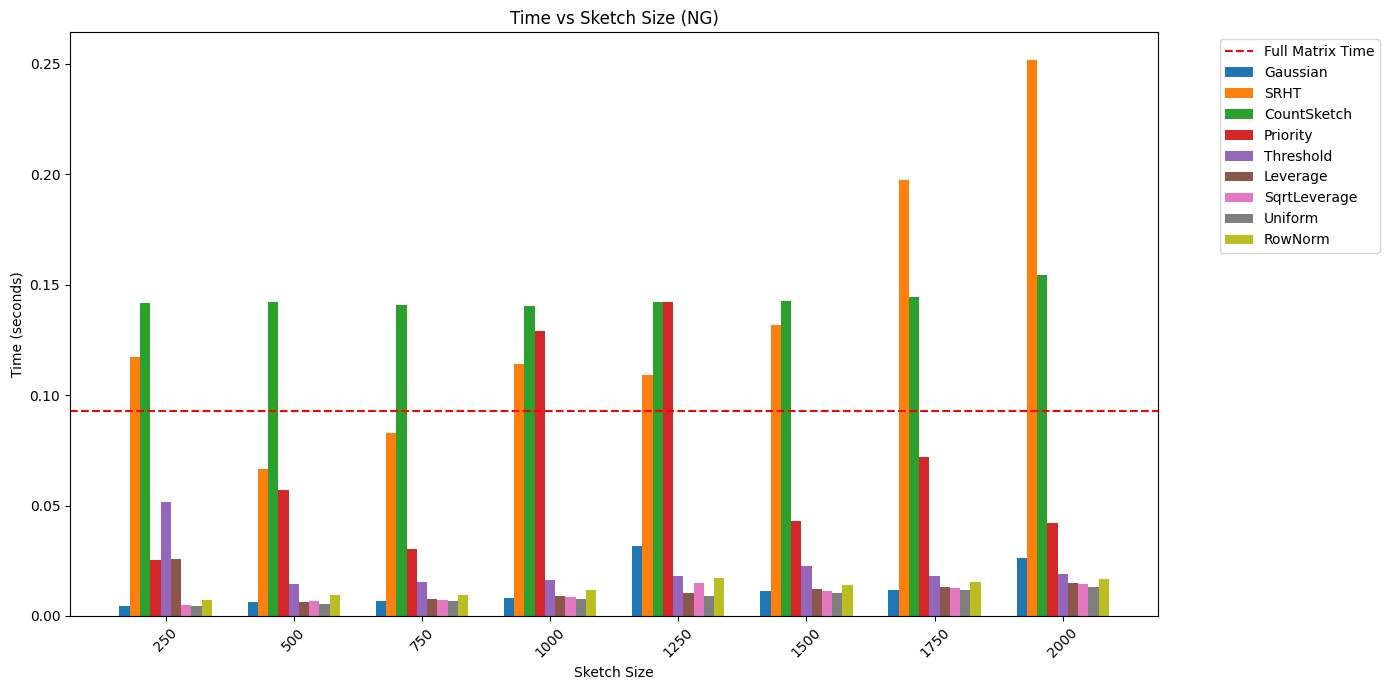

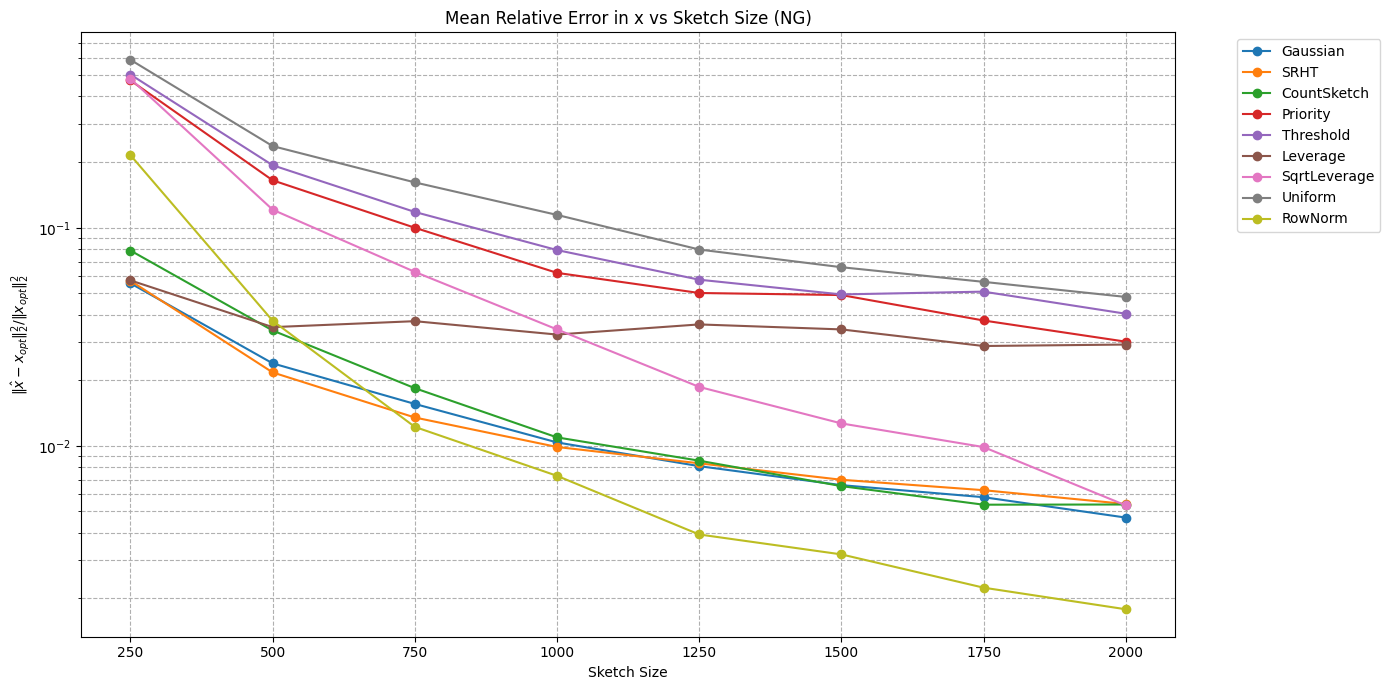

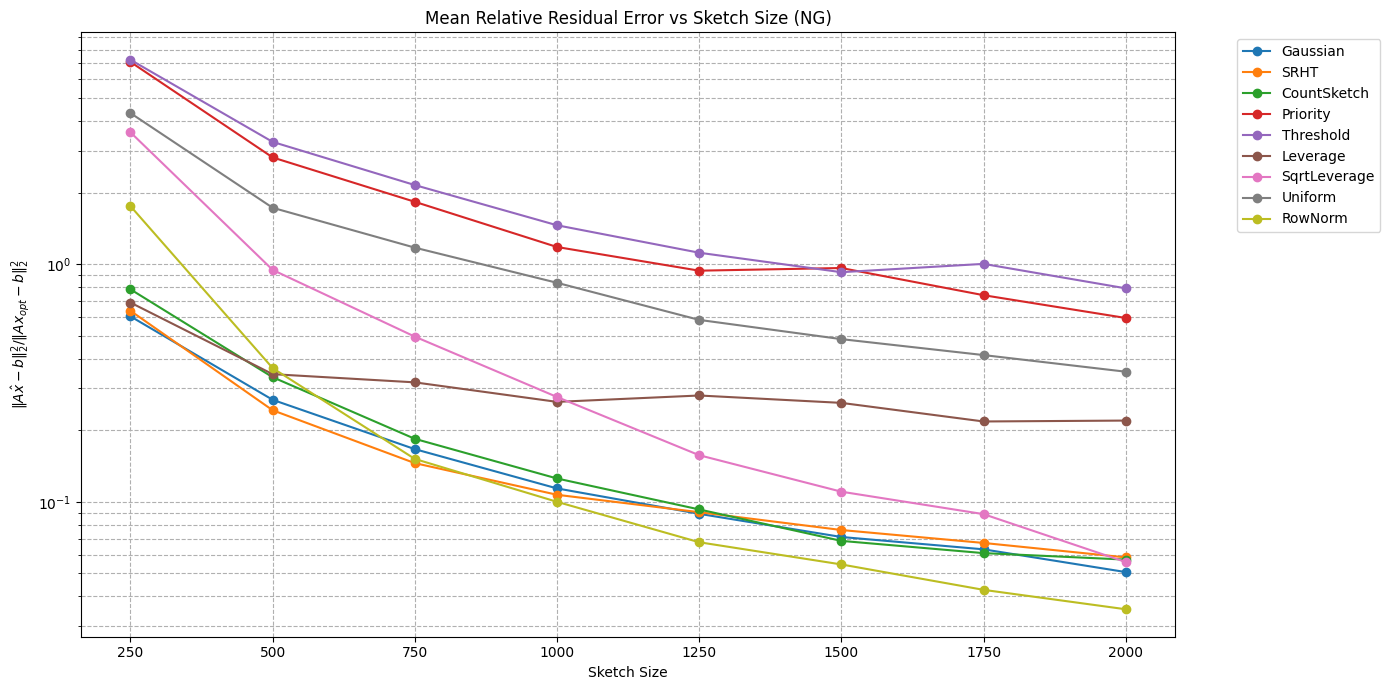

Time for regression: 0.004329681396484375
Time for skecthing: 0.02444601058959961
Time for regression: 0.0043125152587890625
Time for skecthing: 0.02185535430908203
Time for regression: 0.004377126693725586
Time for skecthing: 0.02217245101928711
Time for regression: 0.004480600357055664
Time for skecthing: 0.02227187156677246
Time for regression: 0.004374027252197266
Time for skecthing: 0.02232837677001953
Time for regression: 0.00540614128112793
Time for skecthing: 0.06287121772766113
Time for regression: 0.005468130111694336
Time for skecthing: 0.06360840797424316
Time for regression: 0.005407094955444336
Time for skecthing: 0.05193281173706055
Time for regression: 0.005493640899658203
Time for skecthing: 0.0710759162902832
Time for regression: 0.005476951599121094
Time for skecthing: 0.07435917854309082
Time for regression: 0.006613492965698242
Time for skecthing: 0.09470963478088379
Time for regression: 0.006532430648803711
Time for skecthing: 0.06201338768005371
Time for regressi

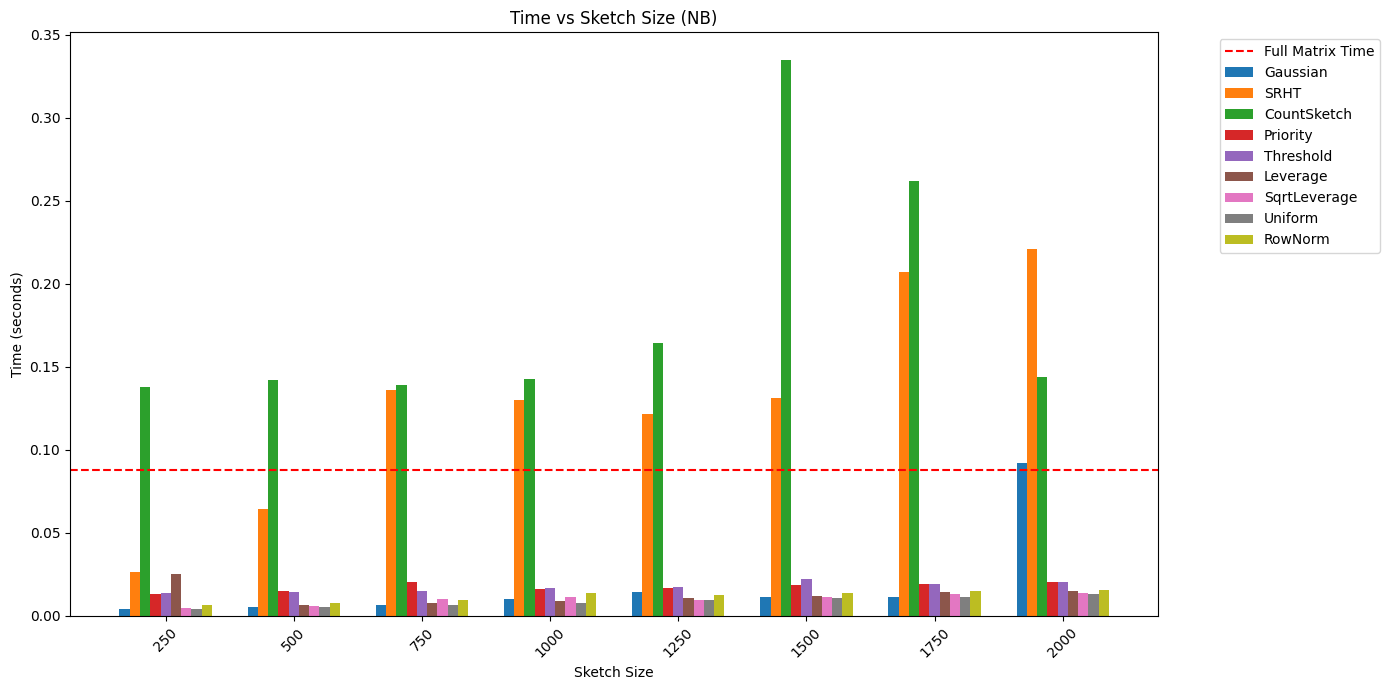

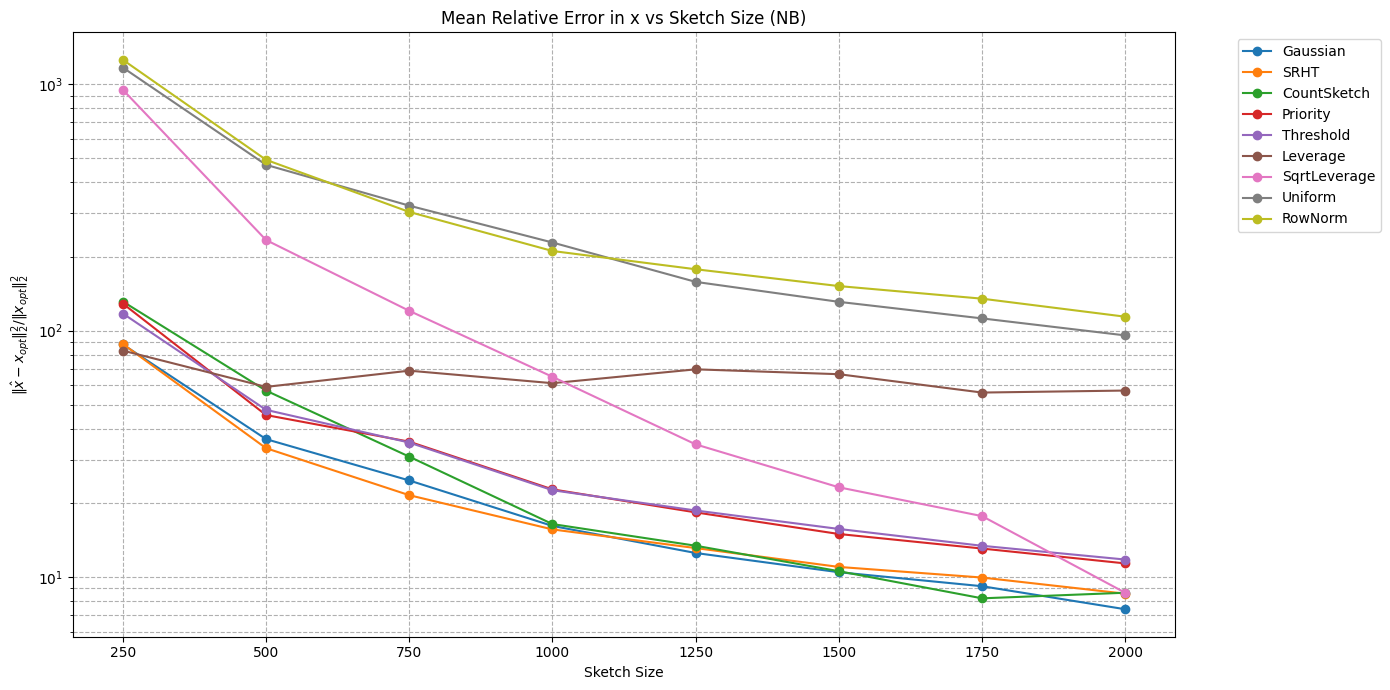

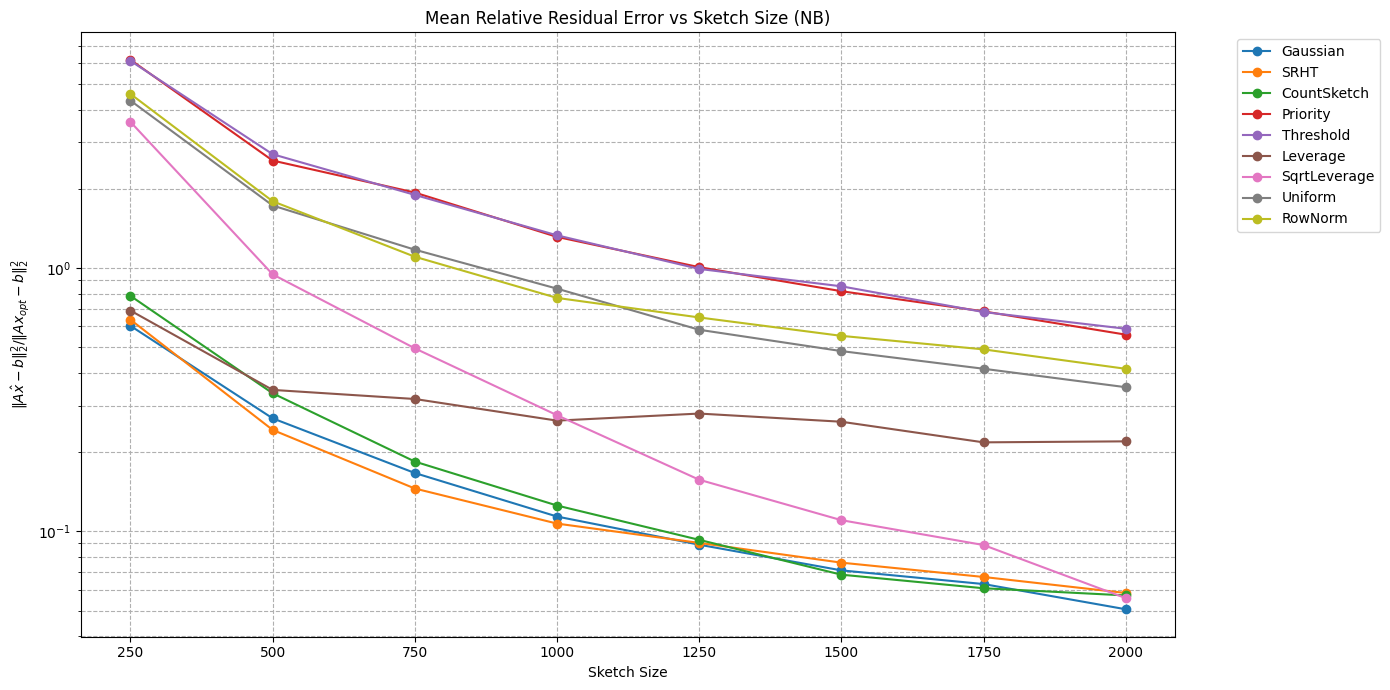

Summary:

Matrix UG:
  Full Matrix Time: 0.0731 seconds

  Sketch Size 250:
    Gaussian:
      Avg Time: 0.0047 seconds
      Avg Error x: 0.086429
      Avg Residual Error: 0.669773
      Avg Sketch Size A: 250.0
      Avg Sketch Size b: 250.0
    SRHT:
      Avg Time: 0.0264 seconds
      Avg Error x: 0.081237
      Avg Residual Error: 0.655734
      Avg Sketch Size A: 250.0
      Avg Sketch Size b: 250.0
    CountSketch:
      Avg Time: 0.1365 seconds
      Avg Error x: 0.078710
      Avg Residual Error: 0.611069
      Avg Sketch Size A: 250.0
      Avg Sketch Size b: 250.0
    Priority:
      Avg Time: 0.0138 seconds
      Avg Error x: 1.256918
      Avg Residual Error: 10.506258
      Avg Sketch Size A: 250.0
      Avg Sketch Size b: 250.0
    Threshold:
      Avg Time: 0.0134 seconds
      Avg Error x: 1.132877
      Avg Residual Error: 9.283761
      Avg Sketch Size A: 255.8
      Avg Sketch Size b: 248.8
    Leverage:
      Avg Time: 0.0251 seconds
      Avg Error x: 0.103449


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Matrix dimensions
m = 10000  # Rows
n = 100    # Columns

# Sketch sizes and trial settings
sketch_sizes = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
num_trials = 5
seeds = [42, 43, 44, 45, 46]

# Compute x_opt and its time
def compute_x_opt(A, b):
    start_time = time.time()
    x_opt, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    end_time = time.time()
    return x_opt, end_time - start_time

# Plotting functions
def plot_time_vs_sketch_size(matrix_type, results, x_opt_time):
    plt.figure(figsize=(14, 7))
    bar_width = 0.08
    x = np.arange(len(sketch_sizes))
    methods = list(results[matrix_type].keys())

    for i, method in enumerate(methods):
        times = [results[matrix_type][method][k]['avg_time'] for k in sketch_sizes]
        plt.bar(x + i * bar_width, times, bar_width, label=method)

    plt.axhline(y=x_opt_time, color='r', linestyle='--', label='Full Matrix Time')
    plt.xlabel('Sketch Size')
    plt.ylabel('Time (seconds)')
    plt.title(f'Time vs Sketch Size ({matrix_type})')
    plt.xticks(x + bar_width * (len(methods) - 1) / 2, sketch_sizes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_error_x_vs_sketch_size(matrix_type, results):
    plt.figure(figsize=(14, 7))
    methods = list(results[matrix_type].keys())

    for i, method in enumerate(methods):
        mean_errors = [np.mean(results[matrix_type][method][k]['error_x']) for k in sketch_sizes]
        plt.plot(sketch_sizes, mean_errors, marker='o', label=method, color=f'C{i}')

    plt.xlabel('Sketch Size')
    plt.ylabel(r'$\|\hat{x} - x_{opt}\|_2^2 / \|x_{opt}\|_2^2$')
    plt.yscale('log')
    plt.title(f'Mean Relative Error in x vs Sketch Size ({matrix_type})')
    plt.xticks(sketch_sizes)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

def plot_residual_error_vs_sketch_size(matrix_type, results):
    plt.figure(figsize=(14, 7))
    methods = list(results[matrix_type].keys())

    for i, method in enumerate(methods):
        mean_errors = [np.mean(results[matrix_type][method][k]['error_residual']) for k in sketch_sizes]
        plt.plot(sketch_sizes, mean_errors, marker='o', label=method, color=f'C{i}')

    plt.xlabel('Sketch Size')
    plt.ylabel(r'$\|A\hat{x} - b\|_2^2 / \|A x_{opt} - b\|_2^2$')
    plt.yscale('log')
    plt.title(f'Mean Relative Residual Error vs Sketch Size ({matrix_type})')
    plt.xticks(sketch_sizes)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    matrix_types = ['UG', 'UB', 'NG', 'NB']
    methods = [
        ('Gaussian', gaussian_sketching),
        ('SRHT', srht_sketching),
        ('CountSketch', countsketch_sketching),
        ('Priority', priority_sampling),
        ('Threshold', threshold_sampling),
        ('Leverage', leverage_score_sampling),
        ('SqrtLeverage', sqrt_leverage_score_sampling),
        ('Uniform', uniform_sampling),
        ('RowNorm', row_norm_sampling)
    ]

    results = {}
    x_opt_times = {}

    for matrix_type in matrix_types:
        # Load pre-generated matrices
        A = np.load(f"matrix_data/A_{matrix_type}.npy")
        b = np.load(f"matrix_data/b_{matrix_type}.npy")

        # Compute x_opt
        x_opt, x_opt_time = compute_x_opt(A, b)
        x_opt_times[matrix_type] = x_opt_time

        results[matrix_type] = {}
        for method_name, method_func in methods:
            results[matrix_type][method_name] = {}
            for k in sketch_sizes:
                times = []
                errors_x = []
                errors_residual = []
                sizes_A = []
                sizes_b = []

                for seed in seeds:
                    x_hat, size_A, size_b, time_taken = method_func(A, b, k, seed=seed)

                    error_x = np.linalg.norm(x_hat - x_opt)**2 / np.linalg.norm(x_opt)**2 if np.linalg.norm(x_opt) > 0 else 0
                    error_residual = np.linalg.norm(A @ x_hat - A @ x_opt)**2 / np.linalg.norm(A @ x_opt - b)**2 if np.linalg.norm(A @ x_opt - b) > 0 else 0
                    times.append(time_taken)
                    errors_x.append(error_x)
                    errors_residual.append(error_residual)
                    sizes_A.append(size_A)
                    sizes_b.append(size_b)

                results[matrix_type][method_name][k] = {
                    'avg_time': np.mean(times),
                    'error_x': errors_x,
                    'error_residual': errors_residual,
                    'avg_size_A': np.mean(sizes_A),
                    'avg_size_b': np.mean(sizes_b)
                }

        # Generate plots for this matrix type
        plot_time_vs_sketch_size(matrix_type, results, x_opt_times[matrix_type])
        plot_error_x_vs_sketch_size(matrix_type, results)
        plot_residual_error_vs_sketch_size(matrix_type, results)

    # Print summary
    print("Summary:")
    for matrix_type in matrix_types:
        print(f"\nMatrix {matrix_type}:")
        print(f"  Full Matrix Time: {x_opt_times[matrix_type]:.4f} seconds")
        for k in sketch_sizes:
            print(f"\n  Sketch Size {k}:")
            for method_name, _ in methods:
                res = results[matrix_type][method_name][k]
                print(f"    {method_name}:")
                print(f"      Avg Time: {res['avg_time']:.4f} seconds")
                print(f"      Avg Error x: {np.mean(res['error_x']):.6f}")
                print(f"      Avg Residual Error: {np.mean(res['error_residual']):.6f}")
                print(f"      Avg Sketch Size A: {res['avg_size_A']:.1f}")
                print(f"      Avg Sketch Size b: {res['avg_size_b']:.1f}")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import time
import os

# Matrix dimensions
m = 10000  # Rows
n = 100    # Columns

# Sketch sizes and trial settings
sketch_sizes = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
num_trials = 5
seeds = [42, 43, 44, 45, 46]

# Cache for leverage scores
leverage_cache = {}
def compute_leverage_scores(A):
    matrix_id = id(A)
    if matrix_id not in leverage_cache:
        ATA = A.T @ A
        ATA_inv = np.linalg.pinv(ATA)
        scores = np.array([A[i] @ ATA_inv @ A[i].T for i in range(A.shape[0])])
        scores = np.maximum(scores, 0)
        leverage_cache[matrix_id] = scores / np.sum(scores) if np.sum(scores) > 0 else np.ones(A.shape[0]) / A.shape[0]
    return leverage_cache[matrix_id]

# Compute x_opt and its time
def compute_x_opt(A, b):
    start_time = time.time()
    x_opt, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    end_time = time.time()
    return x_opt, end_time - start_time

# Main function
def main():
    matrix_types = ['UG', 'UB', 'NG', 'NB']
    methods = [
        ('Gaussian', gaussian_sketching),
        ('SRHT', srht_sketching),
        ('CountSketch', countsketch_sketching),
        ('Priority', priority_sampling),
        ('Threshold', threshold_sampling),
        ('Leverage', leverage_score_sampling),
        ('SqrtLeverage', sqrt_leverage_score_sampling),
        ('Uniform', uniform_sampling),
        ('RowNorm', row_norm_sampling)
    ]

    results = {}
    x_opt_times = {}

    for matrix_type in matrix_types:
        # Load pre-generated matrices
        A = np.load(f"matrix_data/A_{matrix_type}.npy")
        b = np.load(f"matrix_data/b_{matrix_type}.npy")

        # Compute x_opt
        x_opt, x_opt_time = compute_x_opt(A, b)
        x_opt_times[matrix_type] = x_opt_time

        results[matrix_type] = {}
        for method_name, method_func in methods:
            results[matrix_type][method_name] = {}
            for k in sketch_sizes:
                times = []
                errors_x = []
                errors_residual = []
                sizes_A = []
                sizes_b = []

                for seed in seeds:
                    x_hat, size_A, size_b, time_taken = method_func(A, b, k, seed=seed)
                    error_x = np.linalg.norm(x_hat - x_opt)**2 / np.linalg.norm(x_opt)**2 if np.linalg.norm(x_opt) > 0 else 0
                    error_residual = np.linalg.norm(A @ x_hat - A @ x_opt)**2 / np.linalg.norm(A @ x_opt - b)**2 if np.linalg.norm(A @ x_opt - b) > 0 else 0

                    times.append(time_taken)
                    errors_x.append(error_x)
                    errors_residual.append(error_residual)
                    sizes_A.append(size_A)
                    sizes_b.append(size_b)

                results[matrix_type][method_name][k] = {
                    'avg_time': np.mean(times),
                    'avg_error_x': np.mean(errors_x),
                    'avg_error_residual': np.mean(errors_residual),
                    'avg_size_A': np.mean(sizes_A),
                    'avg_size_b': np.mean(sizes_b),
                    'speedup': x_opt_time / np.mean(times) if np.mean(times) > 0 else float('inf')
                }

    # Print summary
    print("Sketching Comparison Results:")
    for matrix_type in matrix_types:
        print(f"\nMatrix {matrix_type}:")
        print(f"  Full Matrix Time: {x_opt_times[matrix_type]:.4f} seconds")
        for k in sketch_sizes:
            print(f"\n  Sketch Size {k}:")
            for method_name, _ in methods:
                res = results[matrix_type][method_name][k]
                print(f"    {method_name}:")
                print(f"      Avg Time: {res['avg_time']:.4f} seconds (Speedup: {res['speedup']:.1f}x)")
                print(f"      Avg Error x: {res['avg_error_x']:.6f}")
                print(f"      Avg Residual Error: {res['avg_error_residual']:.6f}")
                print(f"      Avg Sketch Size A: {res['avg_size_A']:.1f}")
                print(f"      Avg Sketch Size b: {res['avg_size_b']:.1f}")

    # Save results
    output_dir = "sketch_data_all"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for matrix_type in matrix_types:
        for k in sketch_sizes:
            for method_name in [m[0] for m in methods]:
                res = results[matrix_type][method_name][k]
                with open(os.path.join(output_dir, f"stats_{matrix_type}_{method_name}_k{k}.txt"), 'w') as f:
                    f.write(f"Avg Error x: {res['avg_error_x']}\n")
                    f.write(f"Avg Residual Error: {res['avg_error_residual']}\n")
                    f.write(f"Avg Time: {res['avg_time']}\n")
                    f.write(f"Speedup: {res['speedup']}\n")
                    f.write(f"Avg Sketch size A: {res['avg_size_A']}\n")
                    f.write(f"Avg Sketch size b: {res['avg_size_b']}\n")
        with open(os.path.join(output_dir, f"full_matrix_time_{matrix_type}.txt"), 'w') as f:
            f.write(f"{x_opt_times[matrix_type]}")

    return results, x_opt_times

if __name__ == "__main__":
    main()

Time for regression: 0.428879976272583
Time for skecthing: 0.11686182022094727
Time for regression: 0.9448211193084717
Time for skecthing: 0.34711289405822754
Time for regression: 0.01253652572631836
Time for skecthing: 0.1708695888519287
Time for regression: 0.0043621063232421875
Time for skecthing: 0.12715554237365723
Time for regression: 0.004334449768066406
Time for skecthing: 0.15133929252624512
Time for regression: 0.005634784698486328
Time for skecthing: 0.04174947738647461
Time for regression: 0.0055086612701416016
Time for skecthing: 0.0776815414428711
Time for regression: 0.005465030670166016
Time for skecthing: 0.04822826385498047
Time for regression: 0.0054569244384765625
Time for skecthing: 0.046239614486694336
Time for regression: 0.005666255950927734
Time for skecthing: 0.04726529121398926
Time for regression: 0.006578922271728516
Time for skecthing: 0.061324357986450195
Time for regression: 0.006606101989746094
Time for skecthing: 0.06100869178771973
Time for regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Sketch sizes and matrix types
sketch_sizes = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
matrix_types = ['UG', 'UB', 'NG', 'NB']
methods = [
    'Gaussian', 'SRHT', 'CountSketch', 'Priority', 'Threshold',
    'Leverage', 'SqrtLeverage', 'Uniform', 'RowNorm'
]

# Plotting functions
def plot_time_vs_sketch_size(matrix_type, results, x_opt_time):
    plt.figure(figsize=(10, 6))
    bar_width = 0.08
    x = np.arange(len(sketch_sizes))

    for i, method in enumerate(methods):
        times = [results[matrix_type][method][k]['avg_time'] for k in sketch_sizes]
        plt.bar(x + i * bar_width, times, bar_width, label=method)

    plt.axhline(y=x_opt_time, color='r', linestyle='--', label='Full Matrix Time')
    plt.xlabel('Sketch Size')
    plt.ylabel('Time (seconds)')
    plt.title(f'Time vs Sketch Size ({matrix_type})')
    plt.xticks(x + bar_width * (len(methods) - 1) / 2, sketch_sizes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"sketch_data_all/time_vs_sketch_size_{matrix_type}.png")
    plt.close()

def plot_error_x_vs_sketch_size(matrix_type, results):
    plt.figure(figsize=(10, 6))

    for i, method in enumerate(methods):
        mean_errors = [results[matrix_type][method][k]['avg_error_x'] for k in sketch_sizes]
        plt.plot(sketch_sizes, mean_errors, marker='o', label=method, color=f'C{i}')

    plt.xlabel('Sketch Size')
    plt.ylabel(r'$\|\hat{x} - x_{opt}\|_2^2 / \|x_{opt}\|_2^2$')
    plt.yscale('log')
    plt.title(f'Mean Relative Error in x vs Sketch Size ({matrix_type})')
    plt.xticks(sketch_sizes)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig(f"sketch_data_all/error_x_vs_sketch_size_{matrix_type}.png")
    plt.close()

def plot_residual_error_vs_sketch_size(matrix_type, results):
    plt.figure(figsize=(10, 6))

    for i, method in enumerate(methods):
        mean_errors = [results[matrix_type][method][k]['avg_error_residual'] for k in sketch_sizes]
        plt.plot(sketch_sizes, mean_errors, marker='o', label=method, color=f'C{i}')

    plt.xlabel('Sketch Size')
    plt.ylabel(r'$\|A\hat{x} - b\|_2^2 / \|A x_{opt} - b\|_2^2$')
    plt.yscale('log')
    plt.title(f'Mean Relative Residual Error vs Sketch Size ({matrix_type})')
    plt.xticks(sketch_sizes)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig(f"sketch_data_all/residual_error_vs_sketch_size_{matrix_type}.png")
    plt.close()

# Main plotting function
def main():
    input_dir = "sketch_data_all"
    results = {}

    # Load results
    for matrix_type in matrix_types:
        results[matrix_type] = {}
        with open(os.path.join(input_dir, f"full_matrix_time_{matrix_type}.txt"), 'r') as f:
            x_opt_time = float(f.read())

        for method in methods:
            results[matrix_type][method] = {}
            for k in sketch_sizes:
                stats_file = os.path.join(input_dir, f"stats_{matrix_type}_{method}_k{k}.txt")
                if os.path.exists(stats_file):
                    with open(stats_file, 'r') as f:
                        lines = f.readlines()
                        metrics = {}
                        for line in lines:
                            key, value = line.strip().split(': ')
                            metrics[key] = float(value)
                        results[matrix_type][method][k] = {
                            'avg_time': metrics['Avg Time'],
                            'avg_error_x': metrics['Avg Error x'],
                            'avg_error_residual': metrics['Avg Residual Error'],
                            'avg_size_A': metrics['Avg Sketch size A'],
                            'avg_size_b': metrics['Avg Sketch size b'],
                            'speedup': metrics['Speedup']
                        }
                else:
                    print(f"Warning: Stats file {stats_file} not found.")

        # Generate plots
        plot_time_vs_sketch_size(matrix_type, results, x_opt_time)
        plot_error_x_vs_sketch_size(matrix_type, results)
        plot_residual_error_vs_sketch_size(matrix_type, results)

    print("Plots generated and saved in sketch_data_all/")

if __name__ == "__main__":
    main()

Plots generated and saved in sketch_data_all/
